In [63]:
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import math
import copy

## Load data

This uses the discharge-voltage curves at each cycle as raw data. Dimensionality is $(100,1000)$, with 100 cycles and 1000 voltage steps at which discharge is measured

In [64]:
data = pickle.load(open(r'../Data/discharge_curves.pkl', 'rb'))

In [65]:
x = np.stack(data["discharge_curves"].values) # reshape data
y = data["cycle_life"].values
print(*x[3])

[1.06593784e+00 1.06586521e+00 1.06579325e+00 1.06572196e+00
 1.06565135e+00 1.06558140e+00 1.06551211e+00 1.06544348e+00
 1.06537549e+00 1.06530815e+00 1.06524145e+00 1.06517539e+00
 1.06510996e+00 1.06504515e+00 1.06498096e+00 1.06491740e+00
 1.06485444e+00 1.06479209e+00 1.06473034e+00 1.06466919e+00
 1.06460863e+00 1.06454866e+00 1.06448927e+00 1.06443046e+00
 1.06437222e+00 1.06431456e+00 1.06425745e+00 1.06420091e+00
 1.06414491e+00 1.06408947e+00 1.06403457e+00 1.06398022e+00
 1.06392639e+00 1.06387310e+00 1.06382033e+00 1.06376808e+00
 1.06371635e+00 1.06366513e+00 1.06361442e+00 1.06356420e+00
 1.06351448e+00 1.06346526e+00 1.06341652e+00 1.06336826e+00
 1.06332048e+00 1.06327318e+00 1.06322634e+00 1.06317996e+00
 1.06313404e+00 1.06308858e+00 1.06304356e+00 1.06299899e+00
 1.06295485e+00 1.06291115e+00 1.06286788e+00 1.06282504e+00
 1.06278261e+00 1.06274060e+00 1.06269899e+00 1.06265780e+00
 1.06261700e+00 1.06257660e+00 1.06253659e+00 1.06249697e+00
 1.06245772e+00 1.062418

In [4]:
np.shape(x) # 124 batteries, 99 cycles, discharge measured at 1000 voltage steps per cycle

(124, 99, 1000)

In [5]:
np.shape(y)

(124,)

([], [])

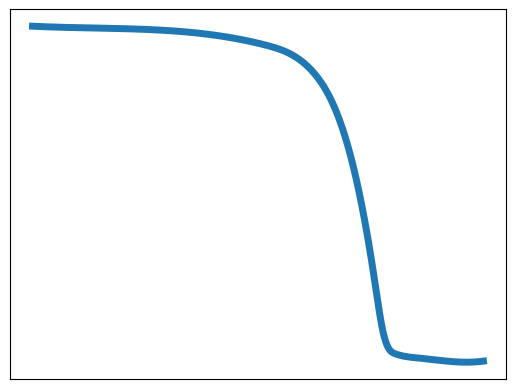

In [27]:
import matplotlib.pyplot as plt
plt.plot(x[1][10], linewidth=5)
plt.xticks([], [])
plt.yticks([], [])

In [66]:
# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

In [67]:
position_embeddings = nn.Parameter(torch.randn(len(x), 99, 1000))

# Add position embedding into patch embedding
input_embeddings = x + position_embeddings

## Split into train/test sets

In [68]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  5,  7,  9, 11, 13, 15, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])

In [69]:
train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(y[secondary_ind]))

## Transformer model

In [12]:
input_embeddings.size()

torch.Size([124, 99, 1000])

In [70]:
# parameters
d_model = 1000
nhead = 8
batch_size = 3
nepoch = 1
batch_first = True

In [161]:
class FullModel(torch.nn.Module):

    def __init__(self, num_heads = 1, num_layers = 2, d_model = 1000, cycles = 99):
        super(FullModel, self).__init__()

        self.conv = nn.Conv1d(1, 5, 5)

        transformer_encoder_layer = nn.TransformerEncoderLayer(
           d_model=d_model, nhead=num_heads,
           dim_feedforward=int(d_model),
           dropout=0.1)

        self.position_embeddings = nn.Parameter(torch.randn(5, d_model))
        self.transformer = nn.TransformerEncoder(
                                encoder_layer=transformer_encoder_layer,
                                num_layers=num_layers)
        self.linear = nn.Linear(d_model, 1) 
        self.initialize_parameters()

    def initialize_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        # Add position embedding into patch embedding
        # x = self.conv(x)
        x = x + self.position_embeddings
        x = self.transformer(x)
        x = torch.sum(x, dim = 0)
        x = self.linear(x)
        return x

In [74]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load nodel, loss function, and optimizer
model = FullModel().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Load batch image
train_dataset = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
# train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)

# # Fine tuning loop
for i in range(14):
    total_loss_train = 0.0

    for cell in train_dataset:
        train_input, train_label = cell
        output = model(train_input.to(device))
        loss = criterion(output, train_label)
        # print(i, output, train_label, loss)

        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    print(f'Epochs: {i + 1} | rmse: {np.sqrt(total_loss_train / len(train_dataset)): .3f}')

/home/rips2023/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 1 | rmse:  528.375
Epochs: 2 | rmse:  352.401
Epochs: 3 | rmse:  334.573
Epochs: 4 | rmse:  319.418
Epochs: 5 | rmse:  327.530
Epochs: 6 | rmse:  343.682


KeyboardInterrupt: 

In [188]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load nodel, loss function, and optimizer
train_dataset = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
test_dataset = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(y[test_ind]))
# model = FullModel().to(device)

In [75]:
a, b = train_dataset[:]
print(model.forward(a))

tensor([[140.5670],
        [141.3454],
        [141.2709],
        [140.6692],
        [142.6330],
        [140.0974],
        [140.8621],
        [141.7834],
        [140.8245],
        [140.2890],
        [139.9865],
        [140.2428],
        [140.5485],
        [142.4058],
        [139.2426],
        [139.2445],
        [141.9502],
        [139.4455],
        [140.7432],
        [139.7126],
        [140.7068],
        [140.4054],
        [140.5249],
        [138.9250],
        [141.2233],
        [139.9308],
        [141.0170],
        [142.6644],
        [141.3556],
        [140.4581],
        [139.4621],
        [140.5439],
        [140.5463],
        [140.9744],
        [141.8000],
        [141.3442],
        [139.7844],
        [138.7811],
        [140.7932],
        [139.8500],
        [142.7467],
        [141.8865],
        [140.6785],
        [139.7984],
        [141.7839],
        [140.4460],
        [140.4326],
        [140.0910],
        [140.4620],
        [140.4345],


## Testing the tranformer encoder regression

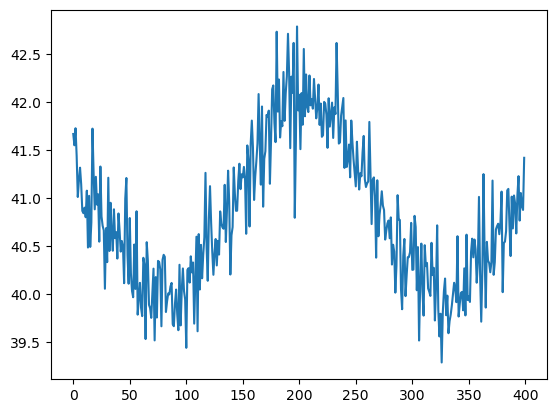

In [170]:
processes = []
means = []

for i in range(500):
    start = np.random.uniform(0, 3)
    xs = np.linspace(start, start+10, 400)
    p = np.sin(xs) + np.random.normal(i//10, 0.3, 400)
    processes.append(p)
    means.append(np.mean(p))

plt.plot(processes[410])

train = TensorDataset(torch.Tensor(processes[:400]),torch.Tensor(means[:400]))
test = TensorDataset(torch.Tensor(processes[400:]),torch.Tensor(means[400:]))

In [169]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load nodel, loss function, and optimizer
model = FullModel(d_model=400, cycles=1).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # Fine tuning loop
for i in range(15):
    total_loss_train = 0.0
    total_loss_test = 0.0

    for cell in train:
        train_input, train_label = cell
        output = model(train_input.expand((1, 400)).to(device))
        loss = criterion(output, train_label)
        

        # print(i, output, train_label, loss)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for cell in test:
        test_input, test_label = cell
        test_output = model(test_input.expand((1, 400)).to(device))
        test_loss = criterion(test_output, test_label)
        

        # print(i, output, train_label, loss)
        total_loss_test += test_loss.item()


    print(f'Epochs: {i + 1} | rmse: {np.sqrt(total_loss_train / len(train)): .3f} | rmse_test: {np.sqrt(total_loss_test / len(test)): .3f}')

/home/rips2023/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 1 | rmse:  6.620 | rmse_test:  6.249
Epochs: 2 | rmse:  3.199 | rmse_test:  6.034
Epochs: 3 | rmse:  3.843 | rmse_test:  5.949
Epochs: 4 | rmse:  4.443 | rmse_test:  5.887
Epochs: 5 | rmse:  4.683 | rmse_test:  5.838


KeyboardInterrupt: 

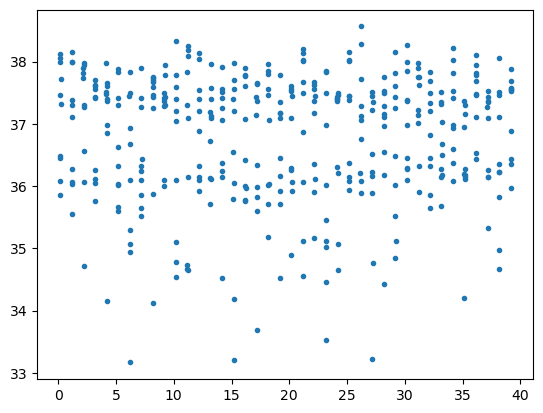

In [163]:
predicted =[]
labels = []
for cell in train:
    train_input, train_label = cell
    predicted.append(model(train_input.expand((1, 400)).to(device)).detach().numpy())
    labels.append(train_label)

plt.plot(labels, predicted, ".")

torch.Size([1, 400])


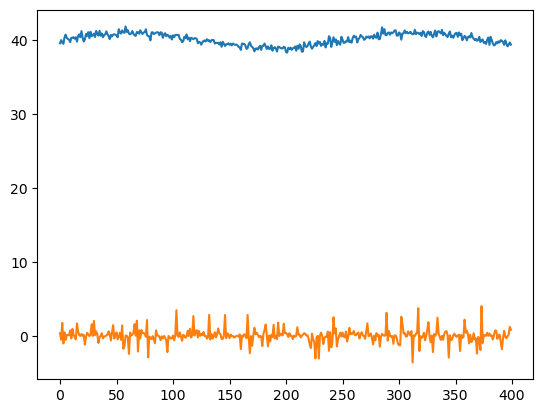

In [164]:
o = model.transformer(test[0][0].expand((1, 400)))
print(o.size())
plt.plot(test[0][0])
plt.plot(o[0].detach().numpy())